# Editing ArcGIS Online Data

Editing data in ArcGIS Online is a very in-demand process as more workflows are moving to the cloud.  While ArcGIS Online makes it much easier for multiple users to edit the same dataset by hand, it presents some problems for automation.  With desktop GIS and local datasets, you have pretty easy access to the table data via databases or shapefiles.  With ArcGIS Online, you only have access to the server.  This means that rather than directly edit the data, you have to interact with the server through the following steps:
 - query the target dataset creating a copy
 - modify your copy of the dataset
 - communicate your changes back to the server
 
Let's suppose (for an example) that we have a project where we're collecting field data.  In this case, we'll use some dummy vegetation data.  Our field users want a useful way to identify their points and communicate to each other once they've collected their data.
 
In desktop programs and databases, ArcGIS provides a special kind of field called an "Auto-Incrementing ID" field.  This helps end users communicate which feature they're talking about in a very human-friendly way.  A lot of data analysts really like this idea, but ArcGIS Online doesn't do that for us.  If we want it, we'll have to do it ourselves.

In [ ]:
# input your specific username
username = input('Username: ')

import arcgis

# set up a GIS object to store your login information and acccess our data.
session_gis = arcgis.GIS('https://arcgis.com',username)

<Item title:"Demo_Vegetation_Data_Base" type:Feature Layer Collection owner:dancranford>
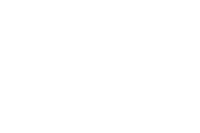

In [3]:
# item containing our vegetation data to edit
item_to_edit = arcgis.gis.Item(session_gis, '11f10170934c413c8db8a40563ed9a4a')
item_to_edit

In [4]:
# let's look for a point layer
all_layers = item_to_edit.layers

for i, layer in enumerate(all_layers):
    print(i, layer.properties.name)

0 Point layer
1 Polygon layer


In [5]:
# We'll be focusing on the point layer for the time being.
lyr_points = all_layers[0]

Now let's take a look at the structure of our feature layer.

In [6]:
df_points = lyr_points.query(as_df=True, return_geometry=False)
df_points.head()

,OBJECTID,GlobalID,CreationDate,Creator,EditDate,Editor,VTYPE,SPECIES,DIAMETER,HEIGHT,AUTO_ID,COUNTY,STATUS,TW_STATUS
0,1,408b9cc9-a9a1-400c-804d-e6f8b617d611,2019-02-26 03:11:55.551000118,dancranford,2020-04-28 13:09:42.109999895,DaveC_BayGeo,Brush,None,NaN,NaN,None,Alameda,Work Prescribed,Assigned
1,2,95a4cc36-a2a8-40de-8809-cd0669322012,2019-02-26 03:12:26.028000116,dancranford,2020-04-28 13:09:42.109999895,DaveC_BayGeo,Tree,None,NaN,NaN,None,Alameda,Complete,Completed
2,3,397a9495-788c-42cb-84c0-aacf7ceef8db,2019-02-26 03:13:02.457999945,dancranford,2020-04-28 13:09:42.109999895,DaveC_BayGeo,Tree,None,NaN,NaN,None,Alameda,Work Prescribed,Unassigned
3,4,cc8409e3-c5a0-42c3-978b-253c216a165f,2019-03-07 03:33:42.572000027,dancranford,2020-04-28 13:09:42.109999895,DaveC_BayGeo,Brush,None,NaN,NaN,None,Riverside,Work Prescribed,Completed
4,5,0660960c-3d81-49a9-8085-d2348dad0a99,2019-03-07 03:38:25.000000000,dancranford,2020-04-28 13:09:42.109999895,DaveC_BayGeo,Tree,None,NaN,NaN,None,Riverside,Inventory,Assigned


In [25]:
# Reset all the values in the AUTO_ID field.
lyr_points.calculate(where='1=1', calc_expression = {'field': 'AUTO_ID', 'value': None})

{'success': True, 'updatedFeatureCount': 8}

Now for this case, we'll assume that we're being asked to do something simple.  We just may just want to format the ID string with a short identifier, then an incrementing number.  In this case, we'll use the format **ID_00001** and increase from there.

So if we think about how we might construct a string in this format that's different for each feature, the first thing we might break it out into the following steps:
 - write a function to turn a number into a formatted string ID
 - set up some logic to make a unique number for each feature
 - apply our function and unique number to each feature
 
We'll start by writing a function for the string formatting.

## Formatting our IDs

Let's use what we already know about strings to insert a number into a pre-formatted string.

In [14]:
print("ID_{}".format(1))
print("ID_0000{}".format(1))
print("ID_0000{}".format(10))

ID_1
ID_00001
ID_000010


#### Quick note - .zfill() method

https://www.w3schools.com/python/ref_string_zfill.asp

The .zfill() method is a super handy method for strings that will add leading zeroes.  It'll make sure all our IDs are the same length.  It'll make them look nice.

In [16]:
#note here that we have to cast our int numbers into strings

print("ID_{}".format("1".zfill(5)))
print("ID_{}".format("11".zfill(5)))
print("ID_{}".format("199".zfill(5)))

ID_00001
ID_00011
ID_00199


In [9]:
def format_id(num):
    #change the number to a string
    str_num = str(num)
    # build an ID using .zfill() to pad our number
    new_id = "ID_{}".format(str_num.zfill(5))
    return new_id

In [10]:
format_id(5)

'ID_00005'

## Iterating through multiple IDs

Now that we have some logic that accepts an integer as an input and gives us back a formatted ID, let's see how we can make these IDs unique.

We'll use a for loop to generate a new ID for each feature then count up for each feature.

In [17]:
# start at 1
counter = 1

while counter < 20:
    # call our function for IDs
    print(format_id(counter))
    
    # increase the counter
    counter += 1
    
#make sure you increase the counter.  This is an easy mistake that can lead to an infinite loop :)

ID_00001
ID_00002
ID_00003
ID_00004
ID_00005
ID_00006
ID_00007
ID_00008
ID_00009
ID_00010
ID_00011
ID_00012
ID_00013
ID_00014
ID_00015
ID_00016
ID_00017
ID_00018
ID_00019


## Apply this logic to our features

Now that we've built our IDs and we have set up some logic to create them and increment them up with each feature, let's apply this to our ArcGIS Online features.

First we'll query the layer and receive a **FeatureSet** from the server<br>
https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#featureset

Then we'll modify the **Feature** objects contained in that **FeatureSet**<br>
https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.Feature

In [18]:
# query our feature layer to get a FeatureSet object
fset_points = lyr_points.query(return_geometry=False)

In [19]:
# grab one feature to test
test_feature = fset_points.features[0]
test_feature

{"attributes": {"OBJECTID": 1, "GlobalID": "408b9cc9-a9a1-400c-804d-e6f8b617d611", "CreationDate": 1551150715551, "Creator": "dancranford", "EditDate": 1588079869200, "Editor": "DaveC_BayGeo", "VTYPE": "Brush", "SPECIES": null, "DIAMETER": null, "HEIGHT": null, "AUTO_ID": null, "COUNTY": "Alameda", "STATUS": "Work Prescribed", "TW_STATUS": "Assigned"}}

In [20]:
# format an ID to insert into that feature
id_1 = format_id(1)
id_1

'ID_00001'

In [21]:
# insert our new ID into our feature
test_feature.set_value('AUTO_ID', id_1)
test_feature

{"attributes": {"OBJECTID": 1, "GlobalID": "408b9cc9-a9a1-400c-804d-e6f8b617d611", "CreationDate": 1551150715551, "Creator": "dancranford", "EditDate": 1588079869200, "Editor": "DaveC_BayGeo", "VTYPE": "Brush", "SPECIES": null, "DIAMETER": null, "HEIGHT": null, "AUTO_ID": "ID_00001", "COUNTY": "Alameda", "STATUS": "Work Prescribed", "TW_STATUS": "Assigned"}}

Now that we know that works, let's do the same to all our features.

In [22]:
# start with 1
counter = 1

for feature in fset_points.features:
    # create a new id with the counter
    new_id = format_id(counter)
    
    # insert the new id into a feature
    feature.set_value('AUTO_ID', new_id)
    
    # increase the counter (so we don't have duplicates)
    counter += 1
    

In [23]:
# converting our featureset to DataFrame to check it out is a good way to see what's going on.
fset_points.sdf.head()

,OBJECTID,GlobalID,CreationDate,Creator,EditDate,Editor,VTYPE,SPECIES,DIAMETER,HEIGHT,AUTO_ID,COUNTY,STATUS,TW_STATUS
0,1,408b9cc9-a9a1-400c-804d-e6f8b617d611,2019-02-26 03:11:55.551000118,dancranford,2020-04-28 13:17:49.200000048,DaveC_BayGeo,Brush,None,NaN,NaN,ID_00001,Alameda,Work Prescribed,Assigned
1,2,95a4cc36-a2a8-40de-8809-cd0669322012,2019-02-26 03:12:26.028000116,dancranford,2020-04-28 13:17:49.200000048,DaveC_BayGeo,Tree,None,NaN,NaN,ID_00002,Alameda,Complete,Completed
2,3,397a9495-788c-42cb-84c0-aacf7ceef8db,2019-02-26 03:13:02.457999945,dancranford,2020-04-28 13:17:49.200000048,DaveC_BayGeo,Tree,None,NaN,NaN,ID_00003,Alameda,Work Prescribed,Unassigned
3,4,cc8409e3-c5a0-42c3-978b-253c216a165f,2019-03-07 03:33:42.572000027,dancranford,2020-04-28 13:17:49.200000048,DaveC_BayGeo,Brush,None,NaN,NaN,ID_00004,Riverside,Work Prescribed,Completed
4,5,0660960c-3d81-49a9-8085-d2348dad0a99,2019-03-07 03:38:25.000000000,dancranford,2020-04-28 13:17:49.200000048,DaveC_BayGeo,Tree,None,NaN,NaN,ID_00005,Riverside,Inventory,Assigned


## Pushing Our Edits back to the Server

Now that we've modified our copies of the features, it's time to send this information back to the server.  The way that ArcGIS Online receives our edits is in the form of features.  It will use the OBJECTID or the GlobalID from our feature to figure out which of its own features our edits correspond with.

https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.FeatureLayer.edit_features

In [24]:
lyr_points.edit_features(updates = fset_points.features)

{'addResults': [],
 'updateResults': [{'objectId': 1,
   'uniqueId': 1,
   'globalId': '408b9cc9-a9a1-400c-804d-e6f8b617d611',
   'success': True},
  {'objectId': 2,
   'uniqueId': 2,
   'globalId': '95a4cc36-a2a8-40de-8809-cd0669322012',
   'success': True},
  {'objectId': 3,
   'uniqueId': 3,
   'globalId': '397a9495-788c-42cb-84c0-aacf7ceef8db',
   'success': True},
  {'objectId': 4,
   'uniqueId': 4,
   'globalId': 'cc8409e3-c5a0-42c3-978b-253c216a165f',
   'success': True},
  {'objectId': 5,
   'uniqueId': 5,
   'globalId': '0660960c-3d81-49a9-8085-d2348dad0a99',
   'success': True},
  {'objectId': 6,
   'uniqueId': 6,
   'globalId': '3bac3885-7d48-475a-9945-69ea4a7fadb0',
   'success': True},
  {'objectId': 7,
   'uniqueId': 7,
   'globalId': '71bfee7f-68c9-4ddd-b23d-285e28b3811b',
   'success': True},
  {'objectId': 8,
   'uniqueId': 8,
   'globalId': '9d7e752a-8183-4147-a0d4-2bc6d186d206',
   'success': True}],
 'deleteResults': []}